In [ ]:
# | default_exp param/image

In [ ]:
from torchvision.io import read_image

In [ ]:
# | export
from copy import deepcopy
import fastcore.all as fc
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
import torchvision.transforms as T
from translucid.utils import *

In [ ]:
path = '../examples/image.png'
image = read_image(path).float().div(255)

In [ ]:
from plotly import graph_objects as go


def scatter_plotly(cols):
    x, y, z = cols
    return go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=cols.T))])


def extract_colors(img):
    cols = img.reshape(3, -1)
    return cols

In [ ]:
# | export
# color correlation
cc_svd_sqrt = Tensor([[0.26, 0.09, 0.02],
                      [0.27, 0.00, -0.05],
                      [0.27, -0.09, 0.03]])

cc_norm = cc_svd_sqrt / cc_svd_sqrt.norm(dim=0).max()


def decorr_colors(img):
    perms = ((1, 2, 0), (2, 0, 1)) if img.shape[0] == 3 else ((0, 2, 3, 1), (0, 3, 1, 2))
    return (img.permute(*perms[0]) @ cc_norm.T.to(img.device)).permute(*perms[1])


def to_valid_range(img, clamp=False):
    if not clamp: return torch.sigmoid(img)
    return img.clamp(0, 1)

In [ ]:
x = to_valid_range(image)
# scatter_plotly(extract_colors(x))

In [ ]:
# | export
# From https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/spatial.py
def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""
    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)


def fft_image(shape, sd=0.01):
    *bc, h, w = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = tuple(bc) + freqs.shape + (2,)  # 2 for imaginary and real components
    return torch.randn(*init_val_size) * sd


def fft2img(fft_img: Tensor, shape, scale, decay_power=1.0):
    *_, h, w = shape
    freqs = rfft2d_freqs(h, w)
    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale = torch.tensor(scale, device=fft_img.device).float()[..., None]
    scaled_spectrum_t = scale * fft_img
    if type(scaled_spectrum_t) is not torch.complex64:
        scaled_spectrum_t = torch.view_as_complex(scaled_spectrum_t)
    image = torch.fft.irfftn(scaled_spectrum_t, s=(h, w), norm='ortho')
    magic = 4.0  # Magic constant from Lucid library; increasing this seems to reduce saturation
    image = image / magic
    return image

In [ ]:
# | export

@fc.patch
def set_meta(self: Tensor, x, as_copy=False):
    "Set all metadata in `__dict__`"
    if not hasattr(x, '__dict__'): return
    self.__dict__ = deepcopy(x.__dict__) if as_copy else x.__dict__


# simlar to fastai's TensorBase https://github.com/fastai/fastai/blob/master/fastai/torch_core.py
class TensorBase(Tensor):
    @classmethod
    def __torch_function__(cls, func, types, args=(), kwargs=None):
        kwargs = kwargs or {}
        res = super().__torch_function__(func, types, args, kwargs)
        dict_args = cls._find_args(args) if args else cls._find_args(list(kwargs.values()))
        if dict_args and issubclass(type(res), TensorBase): res.set_meta(dict_args[0], as_copy=True)
        elif dict_args and isinstance(res, (tuple, list)): [r.set_meta(dict_args[0], as_copy=True) for r in res if issubclass(type(r), TensorBase)]
        return res
    
    @staticmethod    
    def _find_args(args):
        x0 = args[0] if isinstance(args[0], (tuple, list)) and args[0] else args
        return [a for a in x0 if issubclass(type(a), TensorBase)]



In [ ]:
# | export

class ImageParam(TensorBase):
    def __new__(cls, data=None, device=None, orig_shape=None, fft=False, decorr=None, **kwargs):
        if data is not None:
            tensor = torch.as_tensor(data, dtype=torch.float32, device=device).as_subclass(cls)
        else: raise ValueError("`data` must be provided.")

        tensor.requires_grad_(True)
        tensor.fft, tensor.orig_shape = fft, orig_shape
        tensor.decorr = decorr or fft
        for k, v in kwargs.items(): setattr(tensor, k, v)
        return tensor

    @staticmethod
    @fc.delegates(__new__, but='data,orig_shape')
    def new(shape, sd=0.01, fft=False, device=default_device, dp=1.0, **kwargs):
        '''Create a new ImageParam with random data'''
        if fft: data = fft_image(shape, sd)
        else: data = torch.randn(shape, dtype=torch.float32) * sd
        return ImageParam(data=data, device=device, fft=fft, orig_shape=shape, dp=dp, **kwargs)

    def to_img(self, clamp=False, dp=None, decorr=None):
        img = fft2img(self, self.orig_shape, scale=1.0, decay_power=dp or self.dp) if self.fft else self
        img = decorr_colors(img) if fc.ifnone(decorr,self.decorr) else img
        img.fft, img.decorr = False, False
        return to_valid_range(img, clamp=clamp)

    @fc.delegates(to_img)
    def show(self, ax=None, *args, **kwargs):
        """Display the tensor as an image"""
        tensor = to_cpu(self)
        tensor = torch.no_grad()(tensor.to_img)(*args, **kwargs)
        if tensor.size(0) == 3: tensor = tensor.permute(1, 2, 0)
        ax = ax or plt.subplots()[1]
        ax.imshow(tensor, cmap='gray' if len(self.shape) == 2 else None)
        plt.axis('off')
        return ax

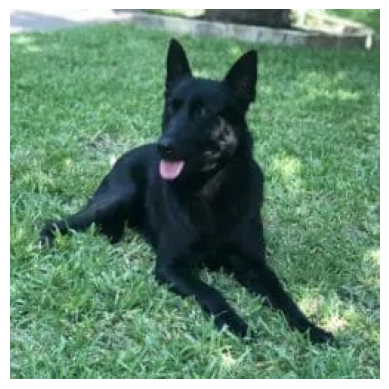

In [ ]:
x = ImageParam(image)
x.show(True)

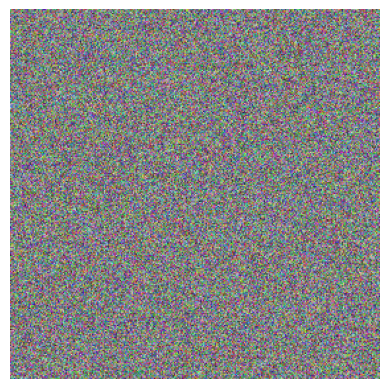

In [ ]:
x = ImageParam.new((3, 280, 280), sd=0.8)
x.show()

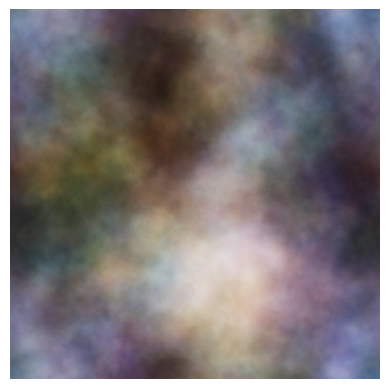

In [ ]:
x = ImageParam.new((3, 280, 280), fft=True, decorr=True)
x.show(dp=1.9)

In [ ]:
#| export

def default_transforms(im_size):
    return [
        T.Pad(12, fill=int(0.5 * 255)),  # Assuming input is in the 0-255 range
        T.RandomCrop(im_size, padding=8),  # Adjust size based on original image size
        T.RandomApply([T.Resize((int(im_size * scale), int(im_size * scale))) for scale in torch.linspace(0.9,1.1,11).numpy()], p=0.5),
        T.RandomRotation(degrees=(-10,10)),
        T.RandomCrop(im_size, padding=4),]

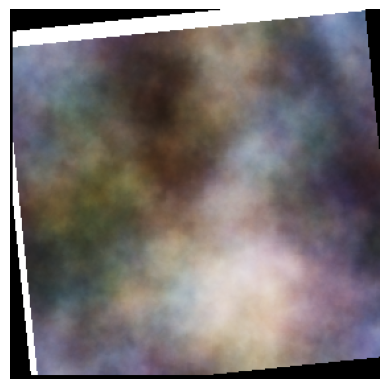

In [ ]:
tfms = T.Compose(default_transforms(280))
res = tfms(x.to_img(dp=1.9))
res.show(True)